# O=O Chemical Lifetime Changes with Time and CH4 Destruction Rate

## File Locations and Relevant Parameters

In [3]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d
import myfunctions as mf

In [4]:
head = "/exports/csce/datastore/geos/users/s1215319/paper3/version2/1dfiles/o2_lifetimes/"

### Standard Photochemistry Directory
stnd = "standard/"
### Accelerated CH4 Directory
fast = "webster_diurnal"

### Solar Longitudes to Plot
ls_study = [0,45,90,135,180,225,270,315,71,251,345]

### CH4 Lifetime's studied
## Lifetimes of CH4 below layer 5 in the model 
enhancements = ['15min', '30min', 'hr', '2hr', '3hr', '4hr', '5hr', '6hr', '12hr', '24hr', 'week' ]#,'month' ,'6month', 'year']
enhancement_labels =['15 min.', '30 min.', '1 Hour',\
                    '2 Hours', '3 Hours', '4 Hours',\
                    '5 Hours', '6 Hours', '12 Hours', '1 Day',\
                    '1 Week']#, '1 Month', '6 Months', '1 Year']

## Curiosity Data

In [5]:
##################
## O2 Data Reading
##################
curi_dir = "/exports/csce/datastore/geos/users/s1215319/paper3/h2o2_effects/curiosity_comparisons/curiosity_data/"

curi_o2_file = open(curi_dir+"trainer_table_S1.txt","r")
curi_o2_lines = curi_o2_file.readlines()[6:] # 6: trims the text header 

curi_o2 = []
curi_ls = []
err_o2_pos = []
err_o2_neg = []

for line in curi_o2_lines:
    ls_curi = float(line.split()[0])
    o2_curi = float(line.split()[10])
    o2_er_pos = float(line.split()[11])
    o2_er_neg = float(line.split()[12])

    curi_o2.append(o2_curi)
    curi_ls.append(ls_curi)
    err_o2_pos.append(o2_er_pos)
    err_o2_neg.append(o2_er_neg)
    
    if ( np.ceil(ls_curi) == 345 ):
        relo2_rover = np.float(o2_curi)
        print(relo2_rover, o2_er_pos, o2_er_neg)


yerr_real = [[],[]]
## Propogation of Errors
## for relative VMR plot
## ---------------------
yerr=[[],[]]
for a in range(0,np.size(err_o2_pos)):
    yerr[0].append(\
                   np.sqrt(\
                          (err_o2_pos[a]/curi_o2[a])**2. \
                    + (3.e-5/0.00153)**2.
                          )\
                  )
    
    yerr[1].append(\
                   np.sqrt(\
                          (err_o2_neg[a]/curi_o2[a])**2. \
                    + (0.00014/0.00153)**2.
                          )\
                  )
    
    yerr_real[0].append(np.float(err_o2_pos[a]))
    yerr_real[1].append(np.float(err_o2_neg[a]))


0.00153 3e-05 0.00014


## Plotting Loop

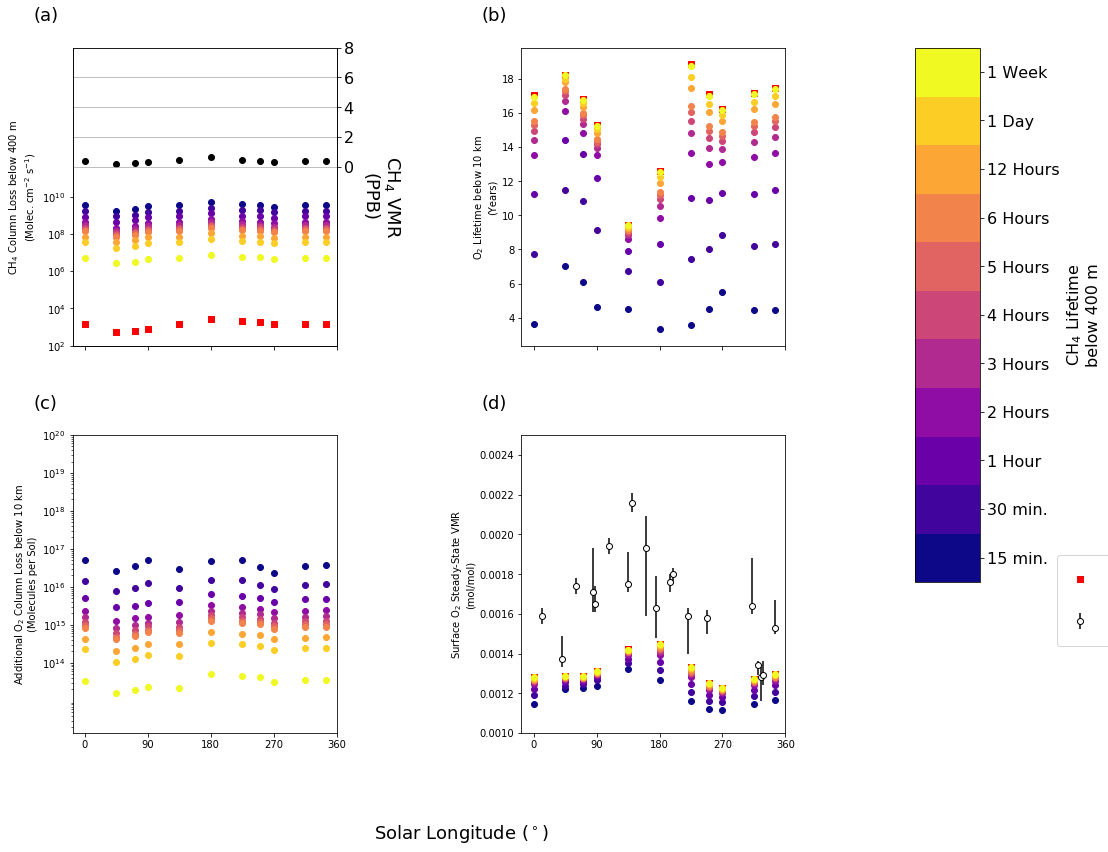

In [6]:
altlimit = 10. ## Limit for lifetime calculations [10. km ~ PBL height]

#### Seconds per year
years = 60.*60.*24.*365.

### Figure Constructions
fig,axs=plt.subplots(2,2,sharex=True,sharey=False)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.grid'] = True

fig.set_figheight(14)
fig.set_figwidth(18)
    
#### Colormap for methane lifetime values
cmap = plt.get_cmap("plasma", len(enhancements))
norm = matplotlib.colors.BoundaryNorm(np.arange(len(enhancements)+1),len(enhancements))
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([]) 

### Place Colormap
fig.subplots_adjust(right=0.75,left=0.2,wspace=0.7,hspace=0.3,bottom=0.2)
cbar_ax = fig.add_axes([0.85, 0.35, 0.05, 0.53])
cb=fig.colorbar(sm, cax=cbar_ax)
cb.ax.set_ylabel("CH$_4$ Lifetime\nbelow 400 m",fontsize=16)
cb.set_ticks(np.arange(0.5,13.5,1))
cb.set_ticklabels(enhancement_labels)

control_label='Standard Chemistry\n(1-D Model)'

### CH4 plot
ch4graph=axs[0,0].twinx()

############################
## Loop One: Solar Longitude
############################
for ls in ls_study:
    
    ### Subdirectory in the 
    ### accelerated CH4 directory
    subdir = "Ls_" + str(ls) 
    
    ### Standard Chemistry file
    ncdf_ctrl = Dataset(head+stnd + "5s_" + str(ls) + "Ls.nc","r")
    
    ### Solar Zenith Angle
    sza = ncdf_ctrl.variables['sza'][:48]
    i = np.where(sza==np.min(sza))[0][0] + 48*2 
    
    ### Altitude (km)
    alt = ncdf_ctrl.variables['altitude'][:]
    z = np.where( alt >= altlimit )[0][0] 
    ### 400 m in model
    z400 = np.where(alt >= 0.4)[0][0]
    
    ### O2 Number Density
    o2_nd_ctrl = ncdf_ctrl.variables['o2_nd'][i,:z]

    ### O2 Column < altlimit
    dz = np.empty(z)
    dz[0] = alt[0]*1000.*100. ## km --> cm 
    for l in range(1,z):
        dz[l] = (alt[l] - alt[l-1])*1000.*100. 
    o2_col_ctrl = np.sum( dz*o2_nd_ctrl ) ## cm-2
    
    ### O=O Loss Rate
    oo_rate_ctrl = ncdf_ctrl.variables['o=o_loss_rate'][i,:z]
    oo_colrate_ctrl = np.sum(oo_rate_ctrl*dz)
    
    ### Bond Lifetime below altlimit
    tau_standard = o2_col_ctrl/oo_colrate_ctrl
    
    ### Conversion to years
    tau_standard = tau_standard/years
    
    ### Methane Loss Rate
    ch4_loss_c = ncdf_ctrl.variables['ch4_loss_rate'][i,:z400]
    ch4_loss_col_c = np.sum(ch4_loss_c*dz[:z400])
    
    ### Plot scatter point as black square
    axs[0,1].scatter(ls,tau_standard,marker='s',color='r',label=control_label)
    axs[0,0].scatter(ls,ch4_loss_col_c,marker='s',color='r',label=control_label)
    
    ### O2 Steady-State
    o2c = ncdf_ctrl.variables['steady_o2'][i,0]
    axs[1,1].scatter(ls,o2c,marker='s',color='r')
    
    control_label=None
    
    ######################################
    ### Loop 2: Methane Chemical Lifetimes
    ######################################
    x=0
    for ch4tau in enhancements:
        
        ncdf = Dataset(head+fast+"/"+subdir+"/5s_"+str(ls)+"Ls_" + ch4tau + ".nc", "r")
        
        ### Methane VMR
        if (x==0):
            ch4vmr = ncdf.variables['ch4'][i,0]*ncdf.variables['mmean'][i,0]/16.
            ch4graph.scatter(ls,ch4vmr*1.e9,color='k')
            
        ### O2 Number Density
        o2_nd = ncdf.variables['o2_nd'][i,:z]
        o2_col = np.sum( dz*o2_nd ) ## cm-2

        ### O=O Loss Rate
        oo_rate = ncdf.variables['o=o_loss_rate'][i,:z]
        oo_colrate = np.sum(oo_rate*dz)

        ### Bond Lifetime below altlimit
        tau = o2_col/oo_colrate

        ### Conversion to years
        tau = tau/years
        
        ### CH4 Loss Rate (molec. cm-2 s-1)
        ch4_loss = ncdf.variables['ch4_loss_rate'][i,:z400]
        ch4_col_loss = np.sum(ch4_loss*dz[:z400])
                
        ### Scatter
        color = cmap(x)
        axs[0,1].scatter(ls,tau,color=color)
        axs[0,0].scatter(ls,ch4_col_loss,color=color)
        
        ### Additional O=O Loss Per Sol
        oo_ratesol_ctrl = np.sum(ncdf_ctrl.variables['o=o_loss_rate'][i-24:i+24,:z]*dz,axis=1)
        oo_ratesol = np.sum(ncdf.variables['o=o_loss_rate'][i-24:i+24,:z]*dz,axis=1)
        
        delta = np.sum(oo_ratesol-oo_ratesol_ctrl)*1800. ## 1800. seconds per timestep
        axs[1,0].scatter(ls,delta,color=color)
        
        ### O2 Steady-State
        o2 = ncdf.variables['steady_o2'][i,0]
        axs[1,1].scatter(ls,o2,color=color)
        
        x=x+1
        
### Axis Labels
axs[0,1].set_ylabel("O$_2$ Lifetime below 10 km\n(Years)")
axs[0,0].set_ylabel("CH$_4$ Column Loss below 400 m\n(Molec. cm$^{-2}$ s$^{-1}$)")
axs[1,0].set_ylabel("Additional O$_2$ Column Loss below 10 km\n(Molecules per Sol)")
axs[1,1].set_ylabel("Surface O$_2$ Steady-State VMR\n(mol/mol)")

fig.text(0.5,0.1,"Solar Longitude ($^\circ$)", ha = 'center', va = 'center', fontsize = 18)

######################
## Plot Curiosity Data
######################
axs[1,1].errorbar(np.array(curi_ls),np.array(curi_o2),\
             yerr=yerr_real,\
             linestyle='None',color='k',marker='o', mfc='w',\
                 label='SAM O$_2$\nObservation')

#####################
## Legend
#####################
handles0, labels0 = axs[0,1].get_legend_handles_labels()
handles1, labels1 = axs[1,1].get_legend_handles_labels()

handles0.append(handles1[0])
labels0.append(labels1[0])

fig.legend(handles0,labels0,bbox_to_anchor=(0.9, 0.25), loc = 'center', fontsize = 16)

### (a),(b),(c),(d) labels
axs[0,0].text(-0.15,1.09,"(a)",transform=axs[0,0].transAxes,fontsize=18)
axs[0,1].text(-0.15,1.09,"(b)",transform=axs[0,1].transAxes,fontsize=18)
axs[1,0].text(-0.15,1.09,"(c)",transform=axs[1,0].transAxes,fontsize=18)
axs[1,1].text(-0.15,1.09,"(d)",transform=axs[1,1].transAxes,fontsize=18)

### Log Scale
axs[0,0].set_yscale("log")

### Axis ticks
axs[0,1].set_xticks([0.,90.,180.,270.,360.])
axs[0,1].set_xlim(None,360.)
axs[0,0].set_yticks([1.e2,1.e4,1.e6,1.e8,1.e10])

### Limits
axs[0,0].set_ylim(1.e2,1.e18)
axs[1,1].set_ylim(1.e-3,2.5e-3)

# ch4graph.set_ylim(-1.,1.)
# ch4graph.set_yticks([0.,0.2,0.4,0.6,0.8,1.])

ch4graph.set_ylim(-12.,8.)
ch4graph.set_yticks([0.,2.,4.,6.,8.])

ch4graph.set_ylabel("CH$_4$ VMR\n(PPB)",rotation = 270.)
ch4graph.yaxis.set_label_coords(1.25,0.5)

axs[1,0].set_yscale("log")
axs[1,0].set_yticks([1.e14,1.e15,1.e16,1.e17,1.e18,1.e19,1.e20])

In [30]:
fig.savefig("/exports/csce/datastore/geos/users/s1215319/paper3/version2/figures/FIG2_O2effects_" + fast + ".png",dpi=500)